In [1]:
# %env PYTHONHASHSEED=0
#import QCPipe #Contains functions required for the QC portion of this pipeline
import dropkick as dk #Contains dropkick functions
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
sc.set_figure_params(dpi=80) #Set figure size to 200 dpi for legibility
sc.settings.verbosity = 3 #Set scanpy verbosity to 3 for in depth function run information

In [3]:
import random
np.random.seed(56)
random.seed(56)

In [4]:
import os
os.getcwd()

'/home/yilin/Dropbox (VU Basic Sciences)/mirazul/8808_human'

In [5]:
adata1 = sc.read_h5ad('8808-1.h5ad')
adata2 = sc.read_h5ad('8808-2.h5ad')

In [6]:
batch_name = ['8808-1','8808-2']

In [7]:
adata = adata1.concatenate(adata2,join='outer',fill_value=0,batch_categories=batch_name)

/home/yilin/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [8]:
adata.write_h5ad('8808_concat.h5ad',compression='gzip')

In [9]:
adata = sc.read_h5ad('8808_concat.h5ad')

In [10]:
adata.obs['batch'].value_counts()

8808-2    2588
8808-1    2573
Name: batch, dtype: int64

In [11]:
adata

AnnData object with n_obs × n_vars = 5161 × 27153
    obs: 'batch'

In [12]:
adata.raw = adata

In [13]:
sc.pp.normalize_total(adata)
adata.X = np.arcsinh(adata.X).copy()
sc.pp.scale(adata)
sc.pp.pca(adata,random_state=0)
neighborhood_k = np.sqrt(adata.n_obs).astype(int) 
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca',random_state=0)
sc.tl.umap(adata,min_dist=0.25,random_state=0)
sc.tl.leiden(adata,resolution=2,random_state=0)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:19)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


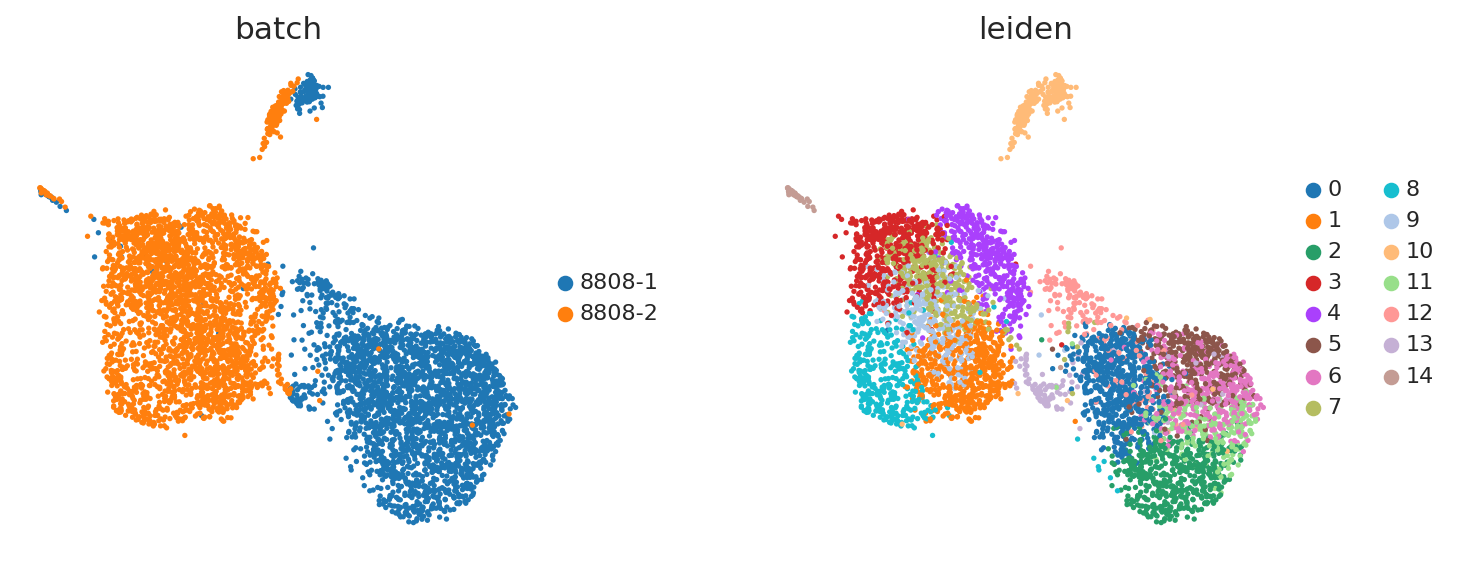

In [14]:
sc.pl.umap(adata,color=['batch','leiden'],legend_fontoutline=True,legend_fontsize=10,cmap='viridis',ncols=3,save='batch.png',wspace=0.3,frameon=False)

In [39]:
import harmonypy as hm

In [40]:
meta_data = pd.DataFrame(adata.obs['batch'])

In [41]:
meta_data

,batch
Cells,
GATAAGACGGATGAAGCA-8808-1,8808-1
ATAGTCGCAATGCGGAT-8808-1,8808-1
GACATTTGTTATATGCAT-8808-1,8808-1
GAGTTTCGACCTTGCC-8808-1,8808-1
AATATACCTAGCGCGAT-8808-1,8808-1
...,...
TGACTTCGCACTCCGTCCA-8808-2,8808-2
ATTCCAGACTGTGGCTA-8808-2,8808-2
TACCGGCATCATGAGG-8808-2,8808-2


In [42]:
vars_use = ['batch']

In [43]:
data_mat = adata.obsm['X_pca'][:,:5]

In [44]:
data_mat.shape

(5161, 5)

In [45]:
ho = hm.run_harmony(data_mat, meta_data, vars_use,max_iter_harmony=50)

2022-10-07 15:16:46,811 - harmonypy - INFO - Iteration 1 of 50
2022-10-07 15:16:47,429 - harmonypy - INFO - Iteration 2 of 50
2022-10-07 15:16:48,034 - harmonypy - INFO - Converged after 2 iterations


In [46]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
#res.to_csv("adj.tsv.gz", sep = "\t", index = False)

In [47]:
adata.obsm['X_pca_harmony'] = res.T.values

In [48]:
sc.pp.neighbors(adata,n_neighbors=neighborhood_k,use_rep='X_pca_harmony',random_state=0)
sc.tl.umap(adata,min_dist=0.25,random_state=0)
sc.tl.leiden(adata,resolution=1,random_state=0)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


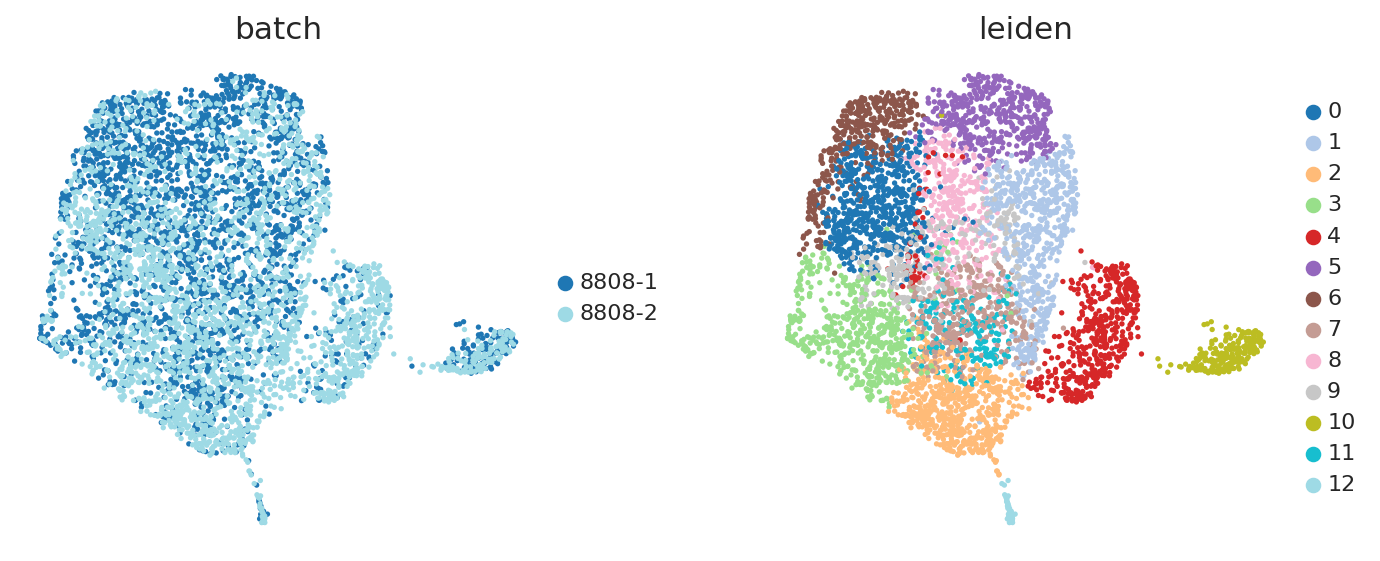

In [53]:
sc.pl.umap(adata,color=['batch','leiden'],legend_fontoutline=True,legend_fontsize=10,palette='tab20',ncols=3,save='batch.png',wspace=0.3,frameon=False)

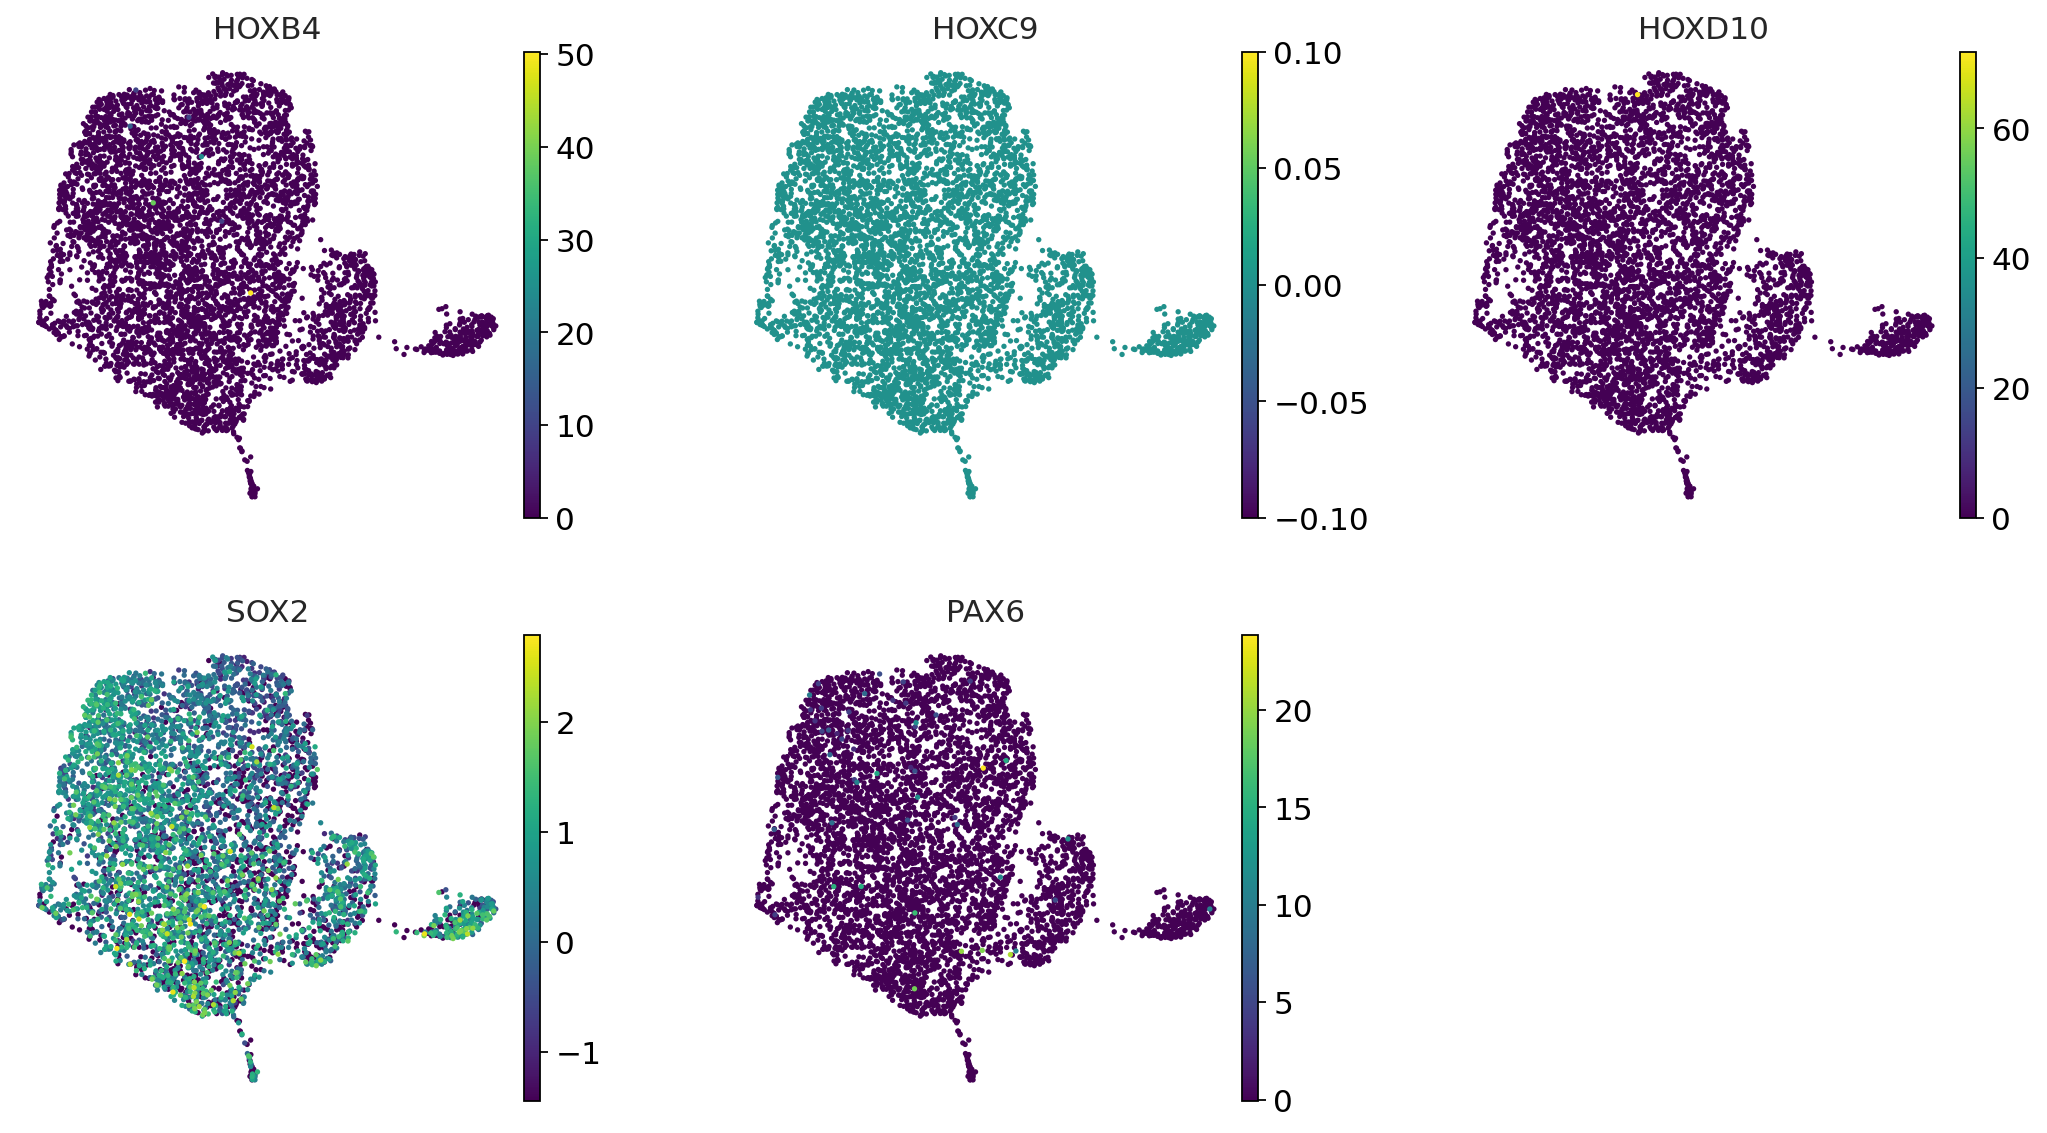

In [50]:
sc.pl.embedding(adata,basis='umap',color=['HOXB4','HOXC9','HOXD10','SOX2','PAX6'],legend_fontoutline=True,use_raw=False,legend_fontsize=10,cmap='viridis',ncols=3,save='gene.png',wspace=0.3,frameon=False)

In [51]:
#perform Diff exp on leiden groups
sc.tl.rank_genes_groups(adata,groupby='leiden',use_raw=True,n_genes=200,method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


In [56]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).to_csv('deg.csv',index=None)